In [1]:
%load_ext autoreload
%autoreload 2

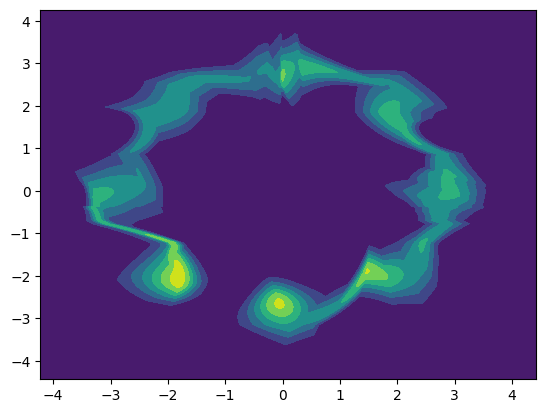

Running experiment for MaskedAffineAutoregressiveFlow_8gaussians_-1:


  0%|          | 0/25 [00:00<?, ?it/s]

Training on 1000 samples.


  0%|          | 0/25 [00:14<?, ?it/s]


KeyboardInterrupt: 

In [30]:
import torch
from datasets import sample_2d_data
from utils import plot_data
from nflow import MaskedAffineAutoregressiveFlowExperiment

gaussians = sample_2d_data("8gaussians", 10000)
exp = MaskedAffineAutoregressiveFlowExperiment("8gaussians", gaussians, -1, retrain_initial=True)
exp()